In [1]:
import pickle
import utils
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(25, 16)}, font_scale=2)
sns.set_style("whitegrid")


%load_ext autoreload
%autoreload 2

# Functions

In [3]:
def graph_stats_with_gt(df, gt_df, mode='local'):
    '''
    Returns an updated `df` that contains the `is_homograph` column for each linkable cell value in the ground truth.
    If a cell value in `df` does not have a corresponding ground-truth set it to np.nan

    `mode` can be either `local` or 'global` to accordingly choose the ground truth 
    '''
    if mode=='local':
        gt_column='is_local_homograph'
    elif mode=='global':
        gt_column='is_homograph'
    
    is_homograph_gt_dict={}
    for idx, row in tqdm(gt_df.iterrows(), total=len(gt_df)):
        is_homograph_gt_dict[row['cell_text']]=row[gt_column]

    is_homograph_list=[]
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        if row['node_type']=='attr':
            is_homograph_list.append(np.nan)
        else:
            if row['node'] in is_homograph_gt_dict:
                is_homograph_list.append(is_homograph_gt_dict[row['node']])
            else:
                is_homograph_list.append(np.nan)

    df['is_homograph']=is_homograph_list
    return df

# Selected Tables (Wikitables 2013)

In [46]:
# Construct the `graph_stats_with_groundtruth_df`
graph_stats=pd.read_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_df.pickle')

# The ground truth homographs are from the local context (i.e., based on only the values that appear in the selected tables) 
is_homograph_gt_df=pd.read_csv('../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/is_homograph_gt_unique_cell_vals.csv')

In [47]:
graph_stats_with_gt=graph_stats_with_gt(df=graph_stats, gt_df=is_homograph_gt_df, mode='local')
graph_stats_with_gt.to_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_with_groundtruth_df.pickle')

100%|██████████| 632192/632192 [00:41<00:00, 15354.00it/s]


## Evaluation

In [3]:
df_path='output/wikitables_datasets/wikipages_2013/selected_csv_tables/'
graph_stats_with_gt = pd.read_pickle(df_path+'graph_stats_with_groundtruth_df.pickle')
with open('../graph_construction/combined_graphs_output/wikitable_datasets/wikipages_2013/selected_csv_tables/bipartite/bipartite.graph', 'rb') as f:
    G=pickle.load(f)
print("Graph has", G.number_of_nodes(), " nodes and", G.number_of_edges(), "edges")
nodes_with_degree_greater_than_1 = [n for n in graph_stats_with_gt['node'].values if G.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'nodes with degree greater than 1')

# Consider only cell nodes with greater than 1 degree
graph_stats_with_gt = graph_stats_with_gt.loc[graph_stats_with_gt['node'].isin(nodes_with_degree_greater_than_1)]

# Consider only nodes for which the ground truth is known and sort by BC
graph_stats_with_gt=graph_stats_with_gt[(graph_stats_with_gt['is_homograph']==True) | (graph_stats_with_gt['is_homograph']==False)].sort_values(by='approximate_betweenness_centrality', ascending=False)
num_true_homographs=len(graph_stats_with_gt[graph_stats_with_gt['is_homograph']==True])
print("There are", num_true_homographs, 'unique homograph values in the ground truth')

Graph has 632192  nodes and 1152408 edges
There are 154711 nodes with degree greater than 1
There are 9991 unique homograph values in the ground truth


Max Precision: 0.9411764705882353 @k= 101
Max F1-Score: 0.43144893899204245 @k= 14136
The are 9991 homographs based on the ground truth.
At k = 9991 the metrics are:
Precision: 0.419777800020018
Recall: 0.419777800020018
F1-Score: 0.419777800020018


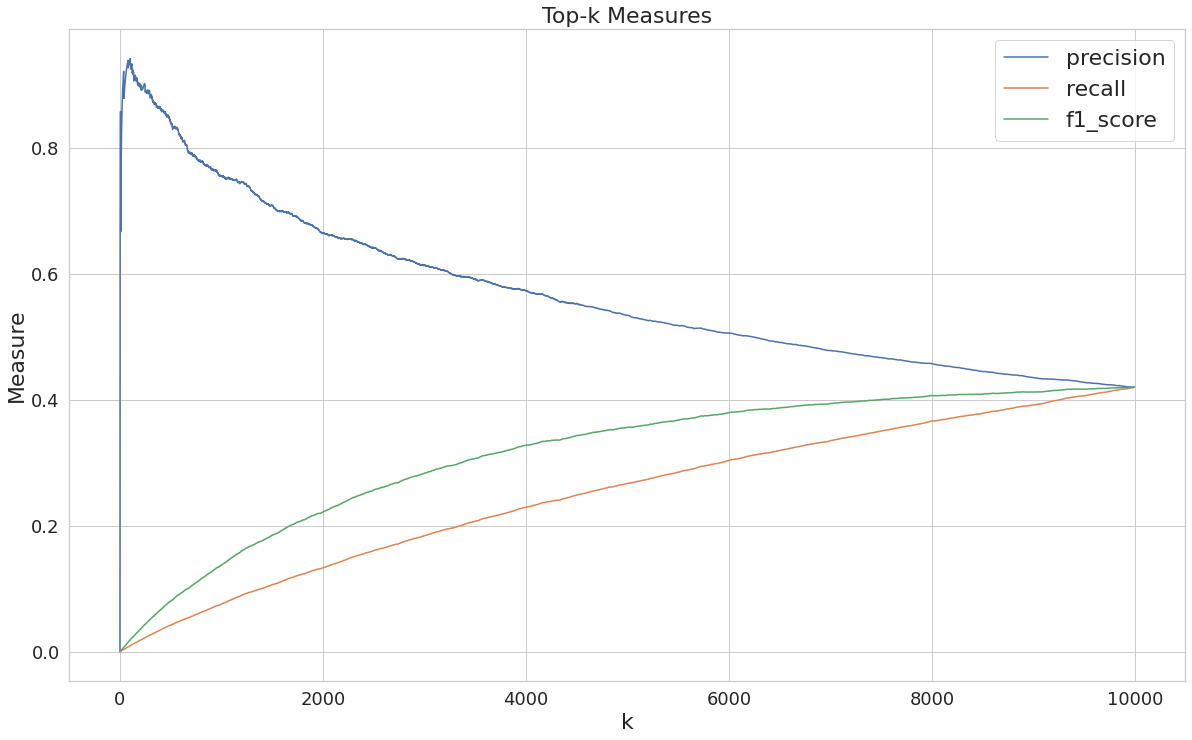

In [4]:
# Compute eval measures at top-k
graph_stats_with_gt = utils.calculate_measures(df=graph_stats_with_gt, num_true_homographs=num_true_homographs)
graph_stats_with_gt=graph_stats_with_gt.reset_index(drop=True)
print("Max Precision:", graph_stats_with_gt['precision'].max(), '@k=', graph_stats_with_gt['precision'].idxmax())
print("Max F1-Score:", graph_stats_with_gt['f1_score'].max(), '@k=', graph_stats_with_gt['f1_score'].idxmax())
utils.topk_evaluation.top_k_graphs(graph_stats_with_gt, output_dir='figures/wikitables_datasets/wikipages_2013/selected_csv_tables/')

### Exploratory Analysis

In [22]:
gt_num_meanings_path='../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/local_homographs_eval_df.csv'
gt_num_meanings_df=pd.read_csv(gt_num_meanings_path)

# Populate the `graph_stats_with_gt_and_metadata` dataframe
graph_stats_with_gt_and_metadata=graph_stats_with_gt.copy()
graph_stats_with_gt_and_metadata['bc_rank']=graph_stats_with_gt_and_metadata.index
num_meanings_list=[]
full_domain_size_list=[]
for idx, row in tqdm(graph_stats_with_gt_and_metadata.iterrows(), total=len(graph_stats_with_gt_and_metadata)):
    if row['is_homograph']:
        num_meanings_list.append(gt_num_meanings_df[gt_num_meanings_df['homograph']==row['node']]['num_meanings'].values[0])
    else:
        num_meanings_list.append(1)
    full_domain_size_list.append(len(utils.graph_helpers.get_cell_node_neighbors(G,row['node'])))

graph_stats_with_gt_and_metadata['num_meanings']=num_meanings_list
graph_stats_with_gt_and_metadata['full_domain_size']=full_domain_size_list

graph_stats_with_gt_and_metadata.to_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_with_gt_and_metadata.pickle')
graph_stats_with_gt_and_metadata

  0%|          | 0/53711 [00:00<?, ?it/s]

100%|██████████| 53711/53711 [00:37<00:00, 1419.92it/s]


,node,node_type,approximate_betweenness_centrality,is_homograph,precision,recall,f1_score,bc_rank,num_meanings,full_domain_size
0,—,cell,0.015888,False,0.000000,0.0000,0.000000,0,1,5021
1,1,cell,0.005550,True,0.500000,0.0001,0.000200,1,39,6937
2,2,cell,0.004985,True,0.666667,0.0002,0.000400,2,43,7549
3,3,cell,0.004597,True,0.750000,0.0003,0.000600,3,33,7567
4,4,cell,0.003916,True,0.800000,0.0004,0.000800,4,30,7306
...,...,...,...,...,...,...,...,...,...,...
53706,IL-19,cell,0.000000,False,0.186028,1.0000,0.313699,53706,1,456
53707,CA-27,cell,0.000000,False,0.186024,1.0000,0.313694,53707,1,456
53708,TX-32,cell,0.000000,False,0.186021,1.0000,0.313689,53708,1,456
53709,TX-01,cell,0.000000,False,0.186018,1.0000,0.313684,53709,1,456


In [2]:
graph_stats_with_gt_and_metadata=pd.read_pickle('output/wikitables_datasets/wikipages_2013/selected_csv_tables/graph_stats_with_gt_and_metadata.pickle')

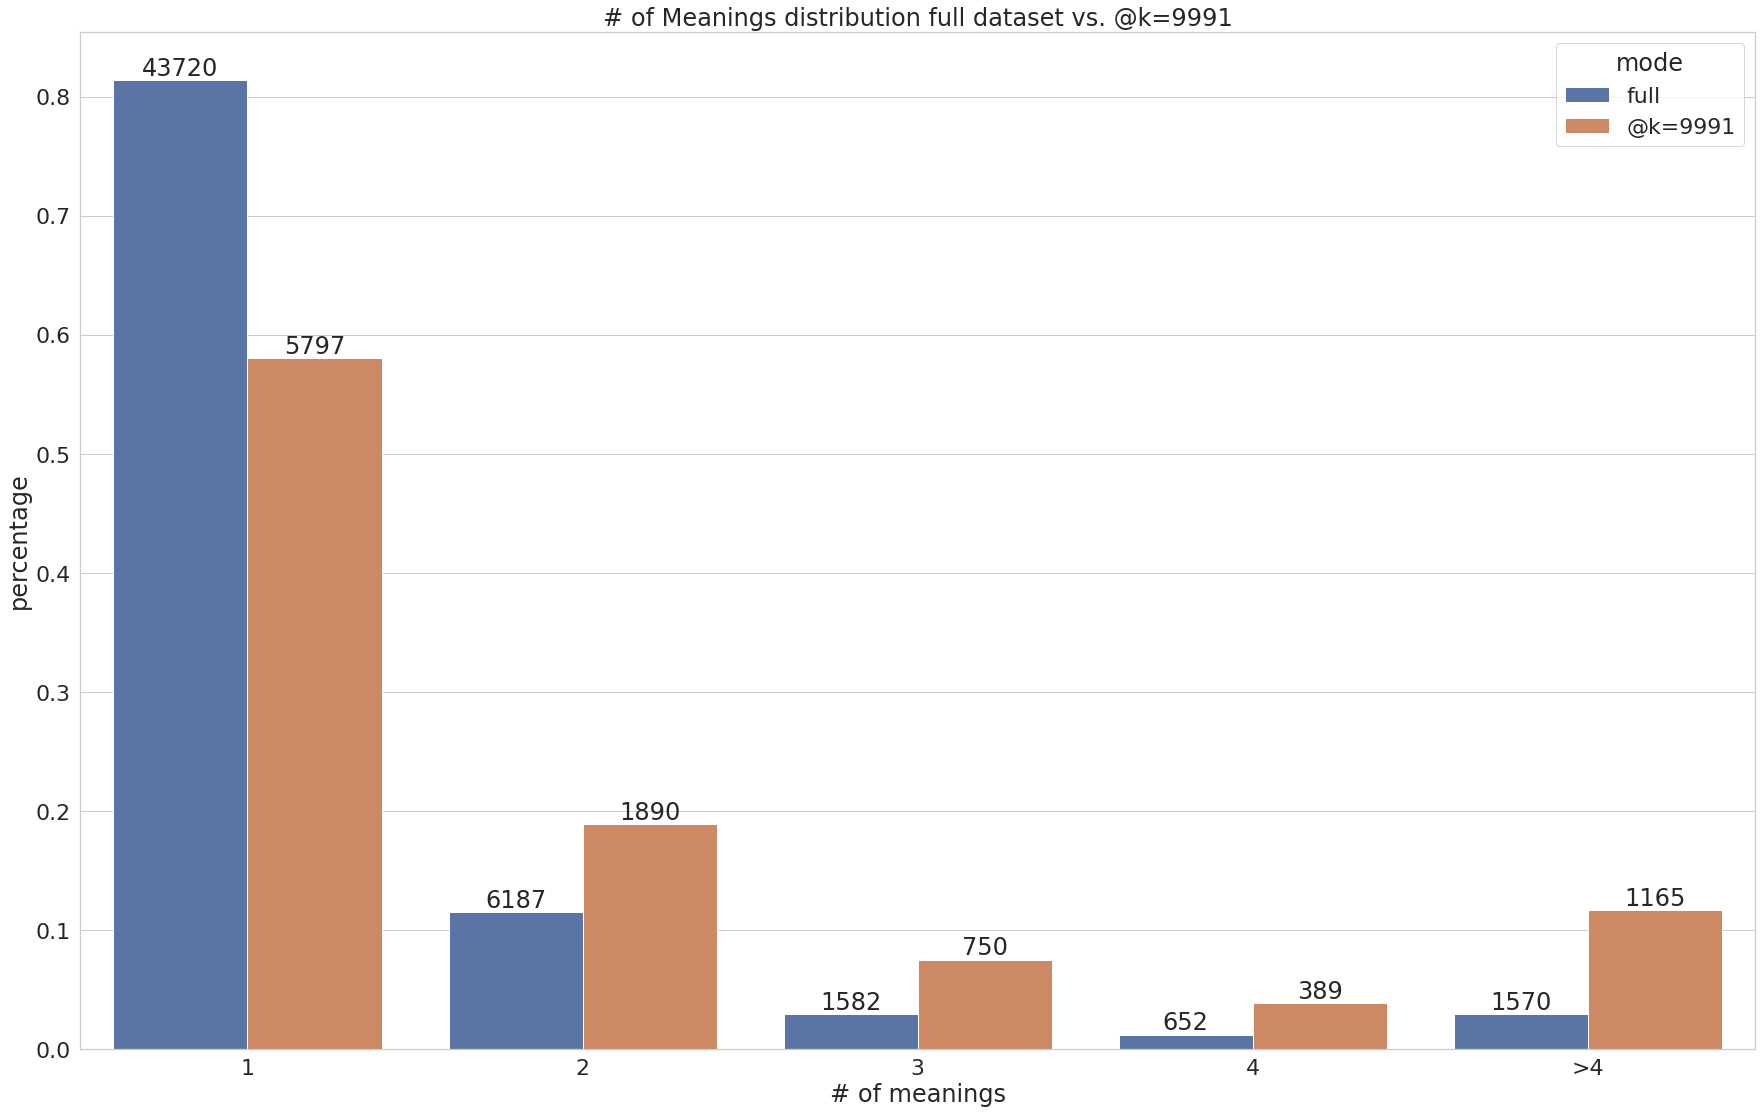

In [25]:
# Distribution of number of meanings (full and @k=num_gt_homographs)
num_meanings_dict={"# of meanings": [], "percentage": [], "count": [], "mode": []}

# Full Dataset
for num_meanings in range(1,5):
    count=len(graph_stats_with_gt_and_metadata[graph_stats_with_gt_and_metadata['num_meanings']==num_meanings])
    percent=count/len(graph_stats_with_gt_and_metadata)
    num_meanings_dict['# of meanings'].append(num_meanings)
    num_meanings_dict['percentage'].append(percent)
    num_meanings_dict['count'].append(count)
    num_meanings_dict['mode'].append('full')
num_meanings_dict['# of meanings'].append('>4')
num_meanings_dict['percentage'].append(len(graph_stats_with_gt_and_metadata[graph_stats_with_gt_and_metadata['num_meanings']>4])/len(graph_stats_with_gt_and_metadata))
num_meanings_dict['count'].append(len(graph_stats_with_gt_and_metadata[graph_stats_with_gt_and_metadata['num_meanings']>4]))
num_meanings_dict['mode'].append('full')

# @k=num_gt_homographs dataset
k=9991
tmp_df=graph_stats_with_gt_and_metadata.head(k)
for num_meanings in range(1,5):
    count=len(tmp_df[tmp_df['num_meanings']==num_meanings])
    percent=count/len(tmp_df)
    num_meanings_dict['# of meanings'].append(num_meanings)
    num_meanings_dict['percentage'].append(percent)
    num_meanings_dict['count'].append(count)
    num_meanings_dict['mode'].append('@k='+str(k))
num_meanings_dict['# of meanings'].append('>4')
num_meanings_dict['percentage'].append(len(tmp_df[tmp_df['num_meanings']>4])/len(tmp_df))
num_meanings_dict['count'].append(len(tmp_df[tmp_df['num_meanings']>4]))
num_meanings_dict['mode'].append('@k='+str(k))

num_meanings_df=pd.DataFrame.from_dict(num_meanings_dict)

ax = sns.barplot(data=num_meanings_df, x="# of meanings", y="percentage", hue='mode', ci=None)
ax.bar_label(ax.containers[0], label_type='edge', labels=num_meanings_df[num_meanings_df['mode']=='full']['count'])
ax.bar_label(ax.containers[1], label_type='edge', labels=num_meanings_df[num_meanings_df['mode']=='@k='+str(k)]['count'])
plt.title('# of Meanings distribution full dataset vs. @k=9991');plt.tight_layout()
plt.savefig('figures/wikitables_datasets/wikipages_2013/selected_csv_tables/num_meanings_distribution.svg')

### Examples

In [12]:
# Identify top BC cell nodes that are non linked cell nodes 
df_path='output/wikitables_datasets/wikipages_2013/selected_csv_tables/'
graph_stats_with_gt = pd.read_pickle(df_path+'graph_stats_with_groundtruth_df.pickle')
with open('../graph_construction/combined_graphs_output/wikitable_datasets/wikipages_2013/selected_csv_tables/bipartite/bipartite.graph', 'rb') as f:
    G=pickle.load(f)
print("Graph has", G.number_of_nodes(), " nodes and", G.number_of_edges(), "edges")
nodes_with_degree_greater_than_1 = [n for n in graph_stats_with_gt['node'].values if G.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'nodes with degree greater than 1')

# Consider only nodes with greater than 1 degree
graph_stats_with_gt = graph_stats_with_gt.loc[graph_stats_with_gt['node'].isin(nodes_with_degree_greater_than_1)]

# Consider only cell nodes
graph_stats_with_gt = graph_stats_with_gt[graph_stats_with_gt['node_type']=='cell']

# Consider only nodes that do not correspond to known linkable entities
graph_stats_with_gt=graph_stats_with_gt[(graph_stats_with_gt['is_homograph']!=True) & (graph_stats_with_gt['is_homograph']!=False)].sort_values(by='approximate_betweenness_centrality', ascending=False)

Graph has 632192  nodes and 1152408 edges
There are 154711 nodes with degree greater than 1


In [13]:
graph_stats_with_gt.head(30)

,node,node_type,approximate_betweenness_centrality,is_homograph
14184,-,cell,0.008312,NaN
3459,Total,cell,0.006131,NaN
8638,?,cell,0.005679,NaN
29546,Source:,cell,0.005265,NaN
26544,Unknown,cell,0.004800,NaN
21022,AP Poll,cell,0.004664,NaN
17282,DNS,cell,0.003024,NaN
809,0,cell,0.002868,NaN
31541,Category:Articles with hCards,cell,0.002673,NaN
22377,Coaches' Poll,cell,0.002614,NaN


# Full Dataset (Wikitables 2013)

In [4]:
# Construct the `graph_stats_with_groundtruth_df`
graph_stats=pd.read_pickle('output/wikitables_datasets/wikipages_2013/csv_tables/graph_stats_df.pickle')

# The ground truth homographs are from the local context (i.e., based on only the values that appear in the selected tables) 
is_homograph_gt_df=pd.read_csv('../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/is_homograph_gt_unique_cell_vals.csv')

graph_stats_with_gt=graph_stats_with_gt(df=graph_stats, gt_df=is_homograph_gt_df, mode='global')
graph_stats_with_gt.to_pickle('output/wikitables_datasets/wikipages_2013/csv_tables/graph_stats_with_groundtruth_df.pickle')

100%|██████████| 8577470/8577470 [08:56<00:00, 15996.28it/s]


## Evaluation

In [ ]:
df_path='output/wikitables_datasets/wikipages_2013/csv_tables/'
graph_stats_with_gt = pd.read_pickle(df_path+'graph_stats_with_groundtruth_df.pickle')
with open('../graph_construction/combined_graphs_output/wikitable_datasets/wikipages_2013/csv_tables/bipartite/bipartite.graph', 'rb') as f:
    G=pickle.load(f)
print("Graph has", G.number_of_nodes(), " nodes and", G.number_of_edges(), "edges")
nodes_with_degree_greater_than_1 = [n for n in graph_stats_with_gt['node'].values if G.degree[n] > 1]
print('There are', len(nodes_with_degree_greater_than_1), 'nodes with degree greater than 1')

# Consider only cell nodes with greater than 1 degree
graph_stats_with_gt = graph_stats_with_gt.loc[graph_stats_with_gt['node'].isin(nodes_with_degree_greater_than_1)]

# Consider only nodes for which the ground truth is known and sort by BC
graph_stats_with_gt=graph_stats_with_gt[(graph_stats_with_gt['is_homograph']==True) | (graph_stats_with_gt['is_homograph']==False)].sort_values(by='approximate_betweenness_centrality', ascending=False)
num_true_homographs=len(graph_stats_with_gt[graph_stats_with_gt['is_homograph']==True])
print("There are", num_true_homographs, 'unique homograph values in the ground truth')

Max Precision: 1.0 @k= 0
Max F1-Score: 0.5845180698067334 @k= 54618
The are 42449 homographs based on the ground truth.
At k = 42449 the metrics are:
Precision: 0.5744069353812811
Recall: 0.5744069353812811
F1-Score: 0.5744069353812811


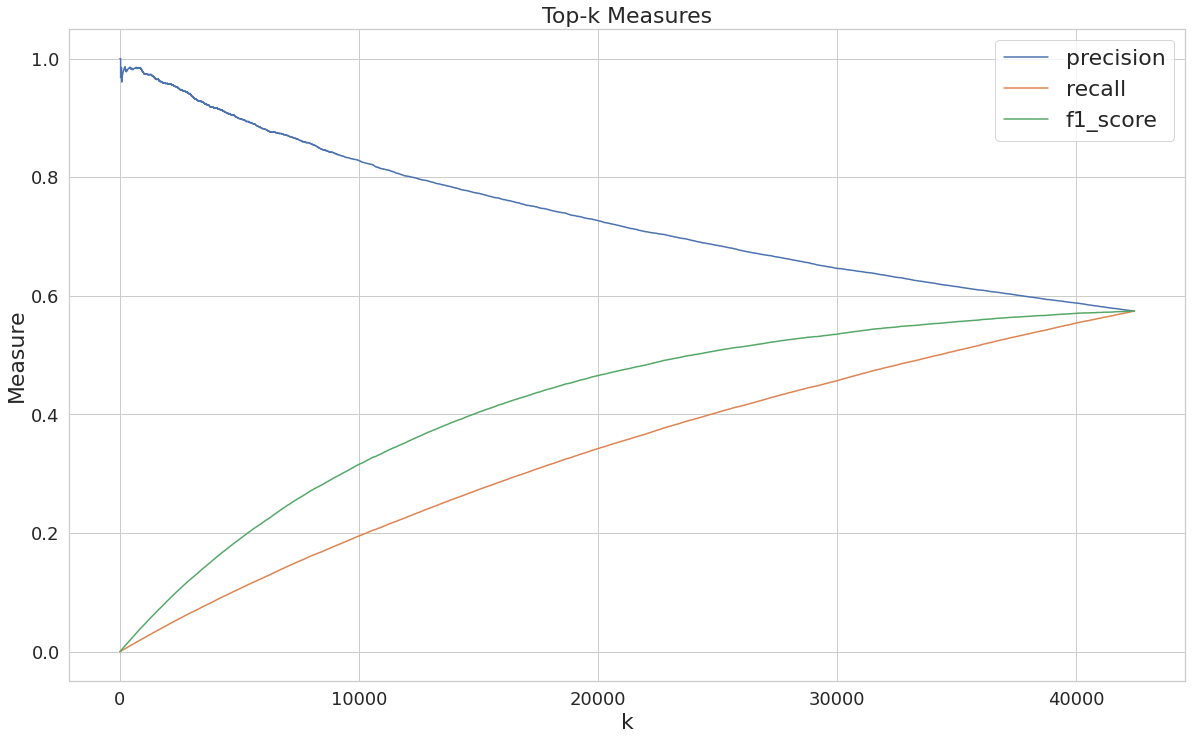

In [7]:
graph_stats_with_gt = utils.calculate_measures(df=graph_stats_with_gt, num_true_homographs=num_true_homographs)
graph_stats_with_gt=graph_stats_with_gt.reset_index(drop=True)
print("Max Precision:", graph_stats_with_gt['precision'].max(), '@k=', graph_stats_with_gt['precision'].idxmax())
print("Max F1-Score:", graph_stats_with_gt['f1_score'].max(), '@k=', graph_stats_with_gt['f1_score'].idxmax())
utils.topk_evaluation.top_k_graphs(graph_stats_with_gt, output_dir='figures/wikitables_datasets/wikipages_2013/csv_tables/')

# Testing

In [14]:
is_homograph_gt_df=pd.read_csv('../../table_search_with_homographs/data/wikipages_2013/gt_data_structures/is_homograph_gt_cell_instances.csv')

In [15]:
val='North America'
is_homograph_gt_df[is_homograph_gt_df['cell_text']==val]

,table_id,pg_title,cell_text,gt_link,gt_wikidata_id,pred_wikidata_id,is_homograph,row_id,col_id,correct_pred,is_local_homograph
120137,1378-368,List of solar eclipses in the 21st century,North America,http://www.wikipedia.org/wiki/North_America,Q49,Q49,True,60,8,True,False
197808,0231-739,List of regicides of Charles I,North America,http://www.wikipedia.org/wiki/North_America,Q49,Q102022333,True,3,3,False,False
205154,1459-450,List of explorers,North America,http://www.wikipedia.org/wiki/North_America,Q49,Q102022333,True,11,3,False,False


In [16]:
print("Column Names:\n", utils.graph_helpers.get_cell_node_column_names(G, val))

table_ids = [val[6:14] for val in utils.graph_helpers.get_cell_node_file_names(G, val)]
print(len(table_ids))
print('page titles:\n', list(is_homograph_gt_df[is_homograph_gt_df['table_id'].isin(table_ids)]['pg_title'].unique()))
# utils.graph_helpers.get_cell_node_neighbors(G, '-')

Column Names:
 ['Unnamed: 0', 'Venue', 'Region', 'Continent', 'Additional information', 'Distribution', 'Geographical area', 'Country', 'Opening act(s)', 'Date', 'Main area/s explored', 'City', 'Notes']
33
page titles:
 ['Alternative Press Tour', 'Wishmaster World Tour', 'My Coach', 'List of Down with Webster concert tours', 'La Luna World Tour', 'Music Saved My Life Tour', 'Breaking Hearts Tour', 'List of solar eclipses in the 21st century', 'Something About Faith Tour', 'Big Bang Alive Galaxy Tour 2012', 'The Family Jewels Tour', 'List of regicides of Charles I', 'Physical Tour', 'List of explorers', 'Boletaceae', 'No Shoes Nation Tour', 'Antivenom', 'Bob Dylan World Tour 1966', 'War', 'Verizon Ladies First Tour', 'List of Beatmania video games', 'The 2nd Law World Tour', 'Watch the Throne Tour', 'Halos & Horns Tour', 'Demographics of the Democratic Republic of the Congo', 'The Monster Ball Tour', 'Black Ice World Tour', 'Live the Life Tour', 'High Flying Birds Tour']
